### Edge Activation Graphs

We could do average of the filters instead of just picking the filter with the highest activation difference. However, taking the filter with the highest feature map weight makes sense as that filter would be most informative to prediction.

#### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from importlib import reload
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga, gc, utils

#### Set up model hyperparameters

In [2]:
second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


### Find the filter with the largest activation

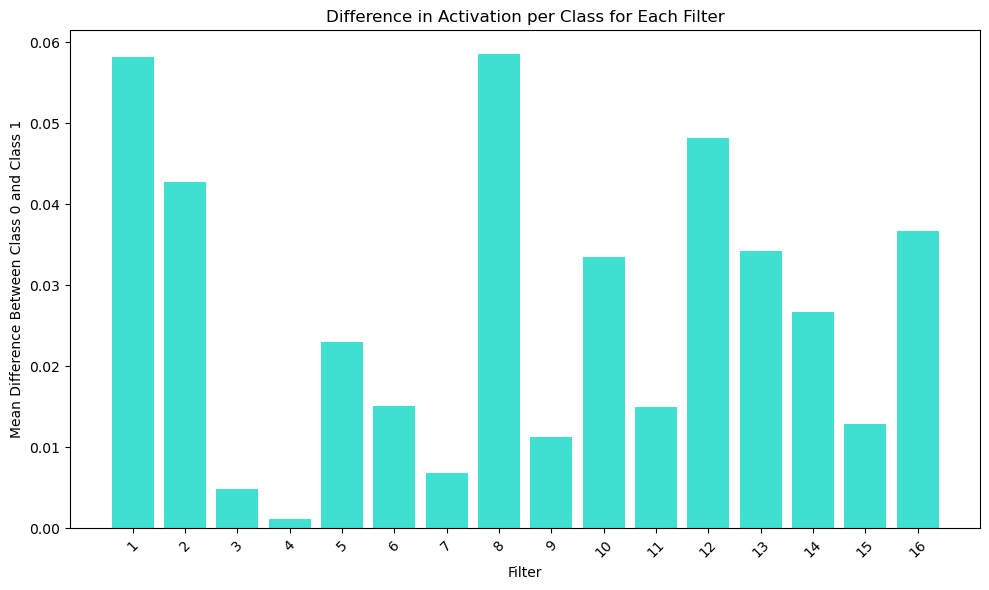

In [3]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, 
                                                     max_events=max_timesteps-1, 
                                                     max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_act_metric_per_feat(model, num_filters, num_patients, 
                                                                             pat_df, max_event_codes, hip_or_knee,
                                                                             'max')
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

In [4]:
max_act_filt_num = ga.find_max_act_filt(mean_activation_df)
max_act_filt_num

8

In [5]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)
logits = model(input_4d, demo_tensor, training=False)
dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0) # change the most recent events to be at the end rather than the start

In [6]:
filters_4d = ga.make_filts_4d(filters, filter_size, max_event_codes)

f = ga.get_and_reshape_filt(filters_4d, max_act_filt_num)
edge_act_graph = ga.filt_times_pat(f, dense_tensor, filter_size, max_timesteps, stride)

In [7]:
edges_df = ga.create_edges_df_ga(dense_tensor, edge_act_graph) 

In [8]:
# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

read_code_pos_df = ga.map_read_code_labels(pos_df, read_code_map_df)

edge_pos_df = ga.create_edge_pos_df(edges_df, pos_df)

In [9]:
ga.plot_edge_act_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, filename='edge_activation_graph')